In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from glob import glob
import os

# Find all matching NetCDF files
#input_pattern = 'tasAdjust_FR-Metro_CNRM-ESM2-1*.nc'
input_pattern = 'tasminAdjust_FR-Metro_CNRM-ESM2-1*.nc'
input_files = glob(input_pattern)

print(f"Found {len(input_files)} files to process")

# Load French departments shapefile
departments = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson")

# Alpine departments codes
alpine_codes = ['04', '05', '06', '26', '38', '73', '74', '84']

# Filter for Alpine departments
alpine_depts = departments[departments['code'].isin(alpine_codes)]
alpine_geometry = alpine_depts.unary_union

# Process each file
for input_file in input_files:
    # Extract date range from filename (last part before .nc)
    basename = os.path.basename(input_file)
    date_range = basename.split('_')[-1].replace('.nc', '')
    
    # Create output filename
#    output_file = f"tasAdjust_alpes_day_{date_range}.nc"
    output_file = f"tasminAdjust_alpes_day_{date_range}.nc"
    
    if os.path.exists(output_file):
        print(f"Output file {output_file} already exists, skipping.")
        continue

    print(f"\nProcessing: {input_file}")
    # Open the dataset
    ds = xr.open_dataset(input_file)
    
    # Create a mask for points within the Alpine region
    mask = xr.zeros_like(ds['lat'], dtype=bool)
    
    # Check each grid point
    for i in range(len(ds.y)):
        for j in range(len(ds.x)):
            lat = float(ds['lat'].isel(y=i, x=j))
            lon = float(ds['lon'].isel(y=i, x=j))
            point = Point(lon, lat)
            if alpine_geometry.contains(point):
                mask[i, j] = True
    
    # Apply mask to all data variables
    ds_masked = ds.where(mask, drop=False)
    
    # Find bounds of valid data
    valid_y = np.where(mask.any(dim='x'))[0]
    valid_x = np.where(mask.any(dim='y'))[0]
    
    if len(valid_y) > 0 and len(valid_x) > 0:
        ds_subset = ds_masked.isel(
            y=slice(valid_y.min(), valid_y.max() + 1),
            x=slice(valid_x.min(), valid_x.max() + 1)
        )
    else:
        ds_subset = ds_masked
    
    # Save to new NetCDF file
    ds_subset.to_netcdf(output_file)
    
    print(f"  Original shape: y={len(ds.y)}, x={len(ds.x)}")
    print(f"  Subset shape: y={len(ds_subset.y)}, x={len(ds_subset.x)}")
    print(f"  Valid grid points: {mask.sum().values}")
    print(f"  Saved to: {output_file}")
    
    # Close datasets
    ds.close()
    ds_subset.close()

print("\nAll files processed!")

Found 13 files to process


/var/folders/p4/zkmdyqzx4qj2tsw_qx64kbsc00gbpc/T/ipykernel_5114/1829880845.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  alpine_geometry = alpine_depts.unary_union



Processing: tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20800101-20891231.nc
  Original shape: y=450, x=461
  Subset shape: y=130, x=98
  Valid grid points: 7318
  Saved to: tasminAdjust_alpes_day_20800101-20891231.nc

Processing: tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20400101-20491231.nc
  Original shape: y=450, x=461
  Subset shape: y=130, x=98
  Valid grid points: 7318
  Saved to: tasminAdjust_alpes_day_20400101-20491231.nc

Processing: tasminAdjust_FR-Metro_CNRM-ESM2-1_ssp370_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-1991-2020_day_20200101-20291231.nc
  Original shape: y=450, x=461
  Subset shape: y=130, x=98
  Valid grid points: 7318
  Saved to: tasminAdjust_alpes_day_20200101-20291231.nc

Processing: tasminAdjust_FR-Metro_CNRM-ESM2-1_historical_r1i1p1f2_CNRM-MF_CNRM-AROME46t1_v1-r1_MF-CDFt-ANASTASIA-ALPX-3-

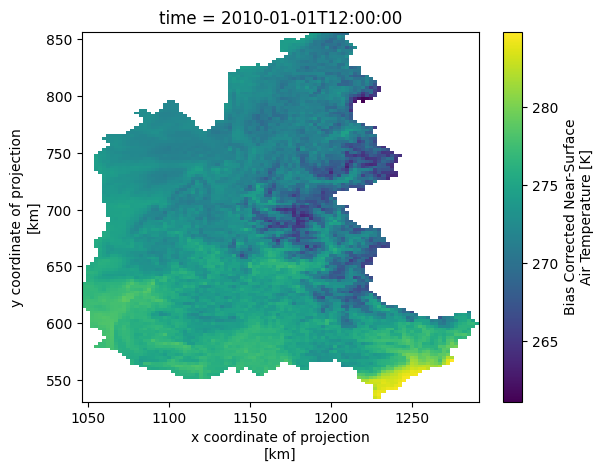

In [14]:
ds = xr.open_dataset('alpes_tasAdjust.nc')
ds.tasAdjust.isel(time=0).plot()

In [12]:
ds

<xarray.Dataset> Size: 45MB
Dimensions:    (time: 1826, bnds: 2, y: 32, x: 38, nv4: 4)
Coordinates:
  * time       (time) datetime64[ns] 15kB 2010-01-01T12:00:00 ... 2014-12-31T...
    lon        (y, x) float64 10kB ...
    lat        (y, x) float64 10kB ...
  * x          (x) float64 304B 1.138e+03 1.14e+03 ... 1.228e+03 1.23e+03
  * y          (y) float64 256B 777.5 780.0 782.5 785.0 ... 850.0 852.5 855.0
Dimensions without coordinates: bnds, nv4
Data variables:
    time_bnds  (time, bnds, y, x) datetime64[ns] 36MB ...
    lon_bnds   (y, x, nv4) float64 39kB ...
    lat_bnds   (y, x, nv4) float64 39kB ...
    tasAdjust  (time, y, x) float32 9MB ...
Attributes: (12/69)
    title:                         CNRM-AROME46t1 model output corrected over...
    summary:                       Data were post-processed by the Météo-Fran...
    id:                            hdl:21.14103/fca09a41-446b-45d5-a5d1-49189...
    Conventions:                   CF-1.11 ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v81
    input_domain:                  Extended Alps
    ...                            ...
    date_created:                  2025-11-17T15:41:21.690418
    product:                       bias-adjusted output
    license:                       https://cordex.org/data-access/cordex-cmip...
    product_version:               v1
    comment:                       Preliminary data released in the Fall 2025...
    keywords:                      temperature, climate, France, near-surface...